In [1]:
import pandas as pd
import numpy as np
from numpy.random import uniform
from numpy import hstack
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

import featuretools as ft
import featuretools.variable_types as vtypes
from sklearn.model_selection import train_test_split, cross_validate

# mlp for multi-output regression
# from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_val_predict

from keras.models import Sequential
from keras.layers import Dense

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import(
    classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
)
from sklearn.preprocessing import (
    StandardScaler, LabelBinarizer, FunctionTransformer,PolynomialFeatures, OrdinalEncoder
)
# from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.multioutput import MultiOutputRegressor,RegressorChain
from sklearn.svm import LinearSVR
# from sklearn.multioutput import RegressorChain
from sklearn_pandas import DataFrameMapper

In [5]:
aa = pd.read_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\AA-NACL.csv',header=0,
                    names=['temp','conductivity','velocity','nacl','aa'],dtype='float32')
df = pd.read_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\AA_NACL_NewFeatures_Corr.csv',dtype='float64')
df_test = pd.read_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\AA_NACL_NewFeatures_Corr_test.csv',dtype='float64')


In [7]:
aa_shuffled = aa.sample(frac=1)
aa_shuffled.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\aa_shuffled.csv')

In [214]:
X_train_df = aa_shuffled.drop(aa_shuffled.iloc[:,3:5],axis=1)
X_train_df

,temp,conductivity,velocity
22,4.0,0.210000,1423.500000
49,10.0,9.530000,1415.900024
53,10.0,9.360000,1421.900024
18,0.0,25.360001,1449.300049
12,0.0,9.330000,1424.500000
...,...,...,...
32,4.0,10.610000,1440.400024
72,15.0,14.480000,1480.800049
13,0.0,9.310000,1424.900024
59,10.0,25.830000,1448.599976


In [215]:
y_train_df = aa_shuffled.iloc[:,3:5]
y_train_df

,nacl,aa
22,0.0,0.5
49,1.0,0.2
53,1.0,2.0
18,3.0,2.0
12,1.0,2.8
...,...,...
32,1.0,2.0
72,1.0,1.0
13,1.0,3.0
59,3.0,1.5


In [59]:
X_train
# X_train_org.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\X_train_org.csv')


,temp,conductivity,velocity
22,4.0,0.210000,1423.500000
49,10.0,9.530000,1415.900024
53,10.0,9.360000,1421.900024
18,0.0,25.360001,1449.300049
12,0.0,9.330000,1424.500000
...,...,...,...
32,4.0,10.610000,1440.400024
72,15.0,14.480000,1480.800049
13,0.0,9.310000,1424.900024
59,10.0,25.830000,1448.599976


In [216]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_df,test_size=0.2,random_state=1)

In [217]:
X_train['mean'] = X_train.mean(axis=1)
X_test['mean'] = X_test.mean(axis=1)


In [218]:
X_train_org = X_train.copy()
X_test_org = X_test.copy()
y_train_org = y_train.copy()
y_test_org = y_test.copy()

In [97]:
#Saving the shuffled splted dataset
X_train_org.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\X_train_org.csv')
X_test_org.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\X_test_org.csv')
y_train_org.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\y_train_org.csv')
y_test_org.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\y_test_org.csv')

#### Let's manually create more features

In [219]:
mapper = DataFrameMapper([
    (['temp'],  [SimpleImputer(strategy='mean')]),
#     (['temp'],  [SimpleImputer(strategy='mean'), OrdinalEncoder()]),
    (['conductivity'],  [SimpleImputer(strategy='mean'), StandardScaler()]),
    (['velocity'],  [SimpleImputer(strategy='mean'), StandardScaler()]),
    (['mean'],  [SimpleImputer(strategy='mean'), StandardScaler()])

], df_out=True)

In [220]:
'''
This class performs feature engineering on the retrieved posts.  It is designed to be used in a pipeline
It takes no special input parameters beyond X (the dataframe to be transformed) and returns a modified version of X
with some additional, calculated columns.
Columns Created:

'''
class TitanicTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
#         X['vel-con'] = X['conductivity']/np.median(X['velocity'])
        X['mean'] = X.mean(axis=1)
        return X
    def fit(self, X, y=None, **fit_params):
        return self

In [221]:
X_train.head(4)

,temp,conductivity,velocity,mean
67,15.0,1.080000,1471.400024,495.826660
43,10.0,0.190000,1404.099976,471.429962
57,10.0,26.120001,1444.900024,493.673340
31,4.0,10.650000,1438.900024,484.516693


In [222]:
pipe1a = Pipeline([
    ('map', mapper),
#     ('feature_gen', TitanicTransformer())
])

In [223]:
pipe1a = pipe1a.fit(X_train)
X_train = pipe1a.transform(X_train)

In [224]:
X_test =  pipe1a.transform(X_test)

### Get Baseline Classification Accuracy Score on this dataframe before we add any new features

#### Start with DecisionTreeClassifier 
* (parameters previously tuned using GridSearchCV on this dataframe)

In [105]:
# X_test =  pipe1a.transform(X_test)

In [106]:
# y_test.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\y_train.csv')

In [107]:
#  from sklearn.metrics import explained_variance_score
# explained_variance_score(y_true, y_pred, multioutput='raw_values')

In [148]:
def run_regression(X_train, y_train,X_test,y_test):
    ESTIMATORS = {
        "K-nn": KNeighborsRegressor(),                          # Accept default parameters
        "Linear regression": LinearRegression(),
        "RandomForestRegressor": RandomForestRegressor(),
        "Decision Tree Regressor":DecisionTreeRegressor(),
        "RegressorChain Regressor":RegressorChain(DecisionTreeRegressor()),
        "MultiOutputRegressor Regressor":MultiOutputRegressor(LinearRegression()),
        "RegressorChain_Linear Regressor":RegressorChain(LinearRegression()),
        "MultiOutput_DecisionTree Regressor":MultiOutputRegressor(DecisionTreeRegressor())
    }
    # 9.1 Create an empty dictionary to collect prediction values
    y_test_predict = dict()
    y_mse = dict()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1) #cross_val_predict
    for name, estimator in ESTIMATORS.items():     
        estimator.fit(X_train, y_train)                    # fit() with instantiated object
        y_test_predict[name] = estimator.predict(X_test)   # Make predictions and save it in dict under key: name
        y_mse[name] = mean_squared_error(y_test, estimator.predict(X_test))
        print('Predicted: %s' % y_mse[name])
    return y_test_predict

In [113]:
y_test_predict = run_regression(X_train, y_train,X_test,y_test)

Predicted: 0.6563714
Predicted: 0.6944399
Predicted: 0.23395320884054635
Predicted: 0.1745238078066283
Predicted: 0.16857142685424734
Predicted: 0.69443995
Predicted: 0.6944400409668366
Predicted: 0.16857142685424734


In [147]:
def run_regression2(X_train, y_train,X_test,y_test):
    ESTIMATORS = {
        "K-nn": KNeighborsRegressor(),# Accept default parameters
        "Linear regression": LinearRegression(),
        "RandomForestRegressor": RandomForestRegressor(),
        "Decision Tree Regressor":DecisionTreeRegressor(),
        "RegressorChain Regressor":RegressorChain(DecisionTreeRegressor()),
        "MultiOutputRegressor Regressor":MultiOutputRegressor(LinearRegression()),
        "RegressorChain_Linear Regressor":RegressorChain(LinearRegression()),
        "MultiOutput_DecisionTree Regressor":MultiOutputRegressor(DecisionTreeRegressor())
    }
    # 9.1 Create an empty dictionary to collect prediction values
    y_test_predict2 = dict()
    y_mse2 = dict()
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    for name, estimator in ESTIMATORS.items():     
        estimator.fit(X_train, y_train)                    # fit() with instantiated object
        n_scores = cross_val_score(estimator, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
        y_test_predict2[name] = cross_val_predict(estimator, X_test, y_test, cv=10)
#         y_test_predict[name] = estimator.predict(X_test)   # Make predictions and save it in dict under key: name
        n_scores = np.absolute(n_scores)
        y_mse2[name] = mean_squared_error(y_test, y_test_predict2)
        print('Predicted: %s' % y_mse2[name])
        print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    return y_test_predict


In [144]:
n_scores1 = run_regression2(X_train, y_train,X_test,y_test)

Predicted: 0.4916666588612969
MAE: 0.606 (0.107)
Predicted: 0.4916666588612969
MAE: 0.590 (0.097)
Predicted: 0.4916666588612969
MAE: 0.224 (0.056)
Predicted: 0.4916666588612969
MAE: 0.220 (0.057)
Predicted: 0.4916666588612969
MAE: 0.232 (0.067)
Predicted: 0.4916666588612969
MAE: 0.590 (0.097)
Predicted: 0.4916666588612969
MAE: 0.590 (0.097)
Predicted: 0.4916666588612969
MAE: 0.231 (0.061)


In [145]:
y_test_predict2

{'K-nn': array([[2.6      , 1.74     ],
        [2.6      , 1.74     ],
        [0.8      , 1.24     ],
        [1.       , 1.5      ],
        [0.8      , 1.24     ],
        [2.6      , 1.74     ],
        [0.       , 1.86     ],
        [1.       , 1.5      ],
        [3.       , 1.24     ],
        [0.2      , 1.3399999],
        [0.       , 1.7      ],
        [0.       , 1.76     ],
        [0.8      , 1.24     ],
        [0.       , 1.5600001],
        [0.2      , 1.3399999],
        [1.       , 1.5      ],
        [0.2      , 1.3399999],
        [0.       , 1.86     ],
        [3.       , 1.24     ],
        [3.       , 1.5600001],
        [0.       , 1.7      ]], dtype=float32),
 'Linear regression': array([[ 3.1233978 ,  1.5348343 ],
        [ 3.223629  ,  1.4731342 ],
        [ 0.996177  ,  1.5172058 ],
        [ 0.8703445 ,  1.2283432 ],
        [ 1.0126185 ,  1.5097932 ],
        [ 3.2016597 ,  1.4835396 ],
        [-0.50039136,  1.7303808 ],
        [ 1.1955798 ,  1.70849

In [150]:
y_test

,nacl,aa
82,3.0,2.8
79,3.0,1.0
97,1.0,3.0
55,1.0,3.0
96,1.0,2.8
80,3.0,1.5
87,0.0,1.5
29,1.0,0.5
102,3.0,2.0
64,0.0,0.5


In [115]:
(print('Predicted K-nn: %s' % y_test_predict['K-nn']),
print('Predicted Linear: %s' % y_test_predict["Linear regression"]),
print('Predicted RandomForestRegressor: %s' % y_test_predict["RandomForestRegressor"]),
print('Predicted Decision Tree: %s' % y_test_predict["Decision Tree Regressor"]),
print('Predicted RegressorChain: %s' % y_test_predict["RegressorChain Regressor"]),
print('Predicted MultiOutputRegressor: %s' % y_test_predict["MultiOutputRegressor Regressor"]),
print('Predicted RegressorChain_Linear Regressor: %s' % y_test_predict['RegressorChain_Linear Regressor']),
print('Predicted MultiOutput_DecisionTree Regressor: %s' % y_test_predict['MultiOutput_DecisionTree Regressor']))

Predicted K-nn: [[2.6       1.74     ]
 [2.6       1.74     ]
 [0.8       1.24     ]
 [1.        1.5      ]
 [0.8       1.24     ]
 [2.6       1.74     ]
 [0.        1.86     ]
 [1.        1.5      ]
 [3.        1.24     ]
 [0.2       1.3399999]
 [0.        1.7      ]
 [0.        1.76     ]
 [0.8       1.24     ]
 [0.        1.5600001]
 [0.2       1.3399999]
 [1.        1.5      ]
 [0.2       1.3399999]
 [0.        1.86     ]
 [3.        1.24     ]
 [3.        1.5600001]
 [0.        1.7      ]]
Predicted Linear: [[ 3.1233978   1.5348343 ]
 [ 3.223629    1.4731342 ]
 [ 0.996177    1.5172058 ]
 [ 0.8703445   1.2283432 ]
 [ 1.0126185   1.5097932 ]
 [ 3.2016597   1.4835396 ]
 [-0.50039136  1.7303808 ]
 [ 1.1955798   1.7084975 ]
 [ 3.6387901   1.1134454 ]
 [-0.16977751  1.8252432 ]
 [ 0.4444574   1.7711705 ]
 [ 0.10702062  1.189177  ]
 [ 1.0134174   1.482079  ]
 [ 0.2506522   1.749537  ]
 [-0.1528393   1.8314497 ]
 [ 0.90251434  1.0975848 ]
 [-0.08481085  1.8913493 ]
 [-0.55974805  1.709437

(None, None, None, None, None, None, None, None)

##### SAVING ALL GENERATED PREDICTIONS


In [117]:
knn_pred=pd.DataFrame(y_test_predict['K-nn'],columns=['nacl','aa'])
lr_pred=pd.DataFrame(y_test_predict['Linear regression'],columns=['nacl','aa'])
rf_pred=pd.DataFrame(y_test_predict['RandomForestRegressor'],columns=['nacl','aa'])
dt_pred=pd.DataFrame(y_test_predict['Decision Tree Regressor'],columns=['nacl','aa'])
rchain_pred=pd.DataFrame(y_test_predict['RegressorChain Regressor'],columns=['nacl','aa'])
multi_or_pred=pd.DataFrame(y_test_predict['MultiOutputRegressor Regressor'],columns=['nacl','aa'])
rchain_linear_pred=pd.DataFrame(y_test_predict['RegressorChain_Linear Regressor'],columns=['nacl','aa'])
multior_dt_pred=pd.DataFrame(y_test_predict['MultiOutput_DecisionTree Regressor'],columns=['nacl','aa'])

# SAVING ALL GENERATED PREDICTIONS
knn_pred.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\knn_pred.csv')
lr_pred.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\lr_pred.csv')
rf_pred.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\rf_pred.csv')
dt_pred.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\dt_pred.csv')
rchain_pred.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\rchain_pred.csv')
multi_or_pred.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\multi_or_pred.csv')
rchain_linear_pred.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\rchain_linear_pred.csv')
multior_dt_pred.to_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\aa-results\\multior_dt_pred.csv')

### Graphical representation and comparison of models

In [254]:
# titanic_df[titanic_df['Survived']==1]['Survived']

def hydrateNaclCurve(df,x,y,c,title,xlab,ylab,cv1,cv2,cv3):
    
    legend_prop = {'weight':'bold','size':20}
    
    plt.plot(df[x].where(df[c] == cv1).dropna(), df[y].where(df[c] == cv1).dropna(),
             color='green',marker='o', label =str(cv1)+'% '+str(c))
    plt.plot(df[x].where(df[c] == cv2).dropna(), df[y].where(df[c] == cv2).dropna(),
             color='blue',marker='o', label =str(cv2)+'% '+str(c))
    plt.plot(df[x].where(df[c] == cv3).dropna(), df[y].where(df[c] == cv3).dropna(),
             color='red',marker='o', label =str(cv3)+'% '+str(c))
    plt.title(title, fontweight='bold',fontsize=15)
    plt.xlabel(xlab,fontsize=15)
    plt.ylabel(ylab,fontsize=15)
    plt.legend(prop=legend_prop)
    

def hydrateNaclCurvePred2(df,df1,x,y,c,title,xlab,ylab,cv1,cv2,cv3):
    
    legend_prop = {'weight':'bold','size':20}
    
    plt.plot(df[x].where(df[c] == cv1).dropna(), df[y].where(df[c] == cv1).dropna(),
             'gp-',linewidth=2, markersize=12, label =str(cv1)+'% '+str(c))
    plt.plot(df1[x].where(df1[c] == cv1).dropna(), df1[y].where(df1[c] == cv1).dropna(),
             'gd--',linewidth=2, markersize=12, label =str(cv1)+'% '+str(c))
    
    plt.plot(df[x].where(df[c] == cv2).dropna(), df[y].where(df[c] == cv2).dropna(),
             'bp-',linewidth=2, markersize=12,  label =str(cv2)+'% '+str(c))
    plt.plot(df1[x].where(df1[c] == cv2).dropna(), df1[y].where(df1[c] == cv2).dropna(),
             'bd--',linewidth=2, markersize=12, label =str(cv2)+'% '+str(c))
    
    plt.plot(df[x].where(df[c] == cv3).dropna(), df[y].where(df[c] == cv3).dropna(),
             'mp-',linewidth=2, markersize=12, label =str(cv3)+'% '+str(c))
    plt.plot(df1[x].where(df1[c] == cv3).dropna(), df1[y].where(df1[c] == cv3).dropna(),
             'mp--',linewidth=2, markersize=12, label =str(cv3)+'% '+str(c))
    
    plt.title(title, fontweight='bold',fontsize=15)
    plt.xlabel(xlab,fontsize=15)
    plt.ylabel(ylab,fontsize=15)
    plt.legend(prop=legend_prop)    
    
    
# titanic_df[titanic_df['Survived']==1]['Survived']
# hydrateNaclCurve(dataset[i],'aa','velocity','nacl',tempt[i]+'c Temperature/Velocity-AA Of AA-NaCl'
#                  ,'Mass Of AA concentration','Velocity',0,1,3)
def hydrateNaclCurvePred3(df,df1,df2,x,y,c,title,xlab,ylab,cv1,cv2,cv3):
    
    legend_prop = {'weight':'bold','size':10}
    
    plt.plot(df[x].where(df[c] == cv1).dropna(), df[y].where(df[c] == cv1).dropna(),
             'gp-',linewidth=2, markersize=12, label =str(cv1)+'% '+str(c))
    plt.plot(df1[x].where(df1[c] == cv1).dropna(), df1[y].where(df1[c] == cv1).dropna(),
             'gd--',linewidth=2, markersize=12, label =str(cv1)+'% '+str(c))
    plt.plot(df2[x].where(df2[c] == cv1).dropna(), df2[y].where(df2[c] == cv1).dropna(),
             'go:',linewidth=2, markersize=12, label =str(cv1)+'% '+str(c))
    
    plt.plot(df[x].where(df[c] == cv2).dropna(), df[y].where(df[c] == cv2).dropna(),
             'bp-',linewidth=2, markersize=12,  label =str(cv2)+'% '+str(c))
    plt.plot(df1[x].where(df1[c] == cv2).dropna(), df1[y].where(df1[c] == cv2).dropna(),
             'bd--',linewidth=2, markersize=12, label =str(cv2)+'% '+str(c))
    plt.plot(df2[x].where(df2[c] == cv2).dropna(), df2[y].where(df2[c] == cv2).dropna(),
             'bp:',linewidth=2, markersize=12, label =str(cv2)+'% '+str(c))
    
    plt.plot(df[x].where(df[c] == cv3).dropna(), df[y].where(df[c] == cv3).dropna(),
             'kp-',linewidth=2, markersize=12, label =str(cv3)+'% '+str(c))
    plt.plot(df1[x].where(df1[c] == cv3).dropna(), df1[y].where(df1[c] == cv3).dropna(),
             'kd--',linewidth=2, markersize=12, label =str(cv3)+'% '+str(c))
    plt.plot(df2[x].where(df2[c] == cv3).dropna(), df2[y].where(df2[c] == cv3).dropna(),
             'ko:',linewidth=2, markersize=12, label =str(cv3)+'% '+str(c))
    
    plt.title(title, fontweight='bold',fontsize=15)
    plt.xlabel(xlab,fontsize=15)
    plt.ylabel(ylab,fontsize=15)
    n

In [225]:
y_test_org

,nacl,aa
82,3.0,2.8
79,3.0,1.0
97,1.0,3.0
55,1.0,3.0
96,1.0,2.8
80,3.0,1.5
87,0.0,1.5
29,1.0,0.5
102,3.0,2.0
64,0.0,0.5


In [226]:
X_test_org_noIndex = X_test_org.copy()
y_test_org_noIndex = y_test_org.copy()
X_test_org_noIndex.reset_index(drop=True, inplace=True)
y_test_org_noIndex.reset_index(drop=True, inplace=True)
X_test_org_noIndex.head()

,temp,conductivity,velocity,mean
0,15.0,37.599998,1506.000000,519.533325
1,15.0,38.680000,1503.699951,519.126648
2,25.0,17.750000,1511.900024,518.216675
3,10.0,9.310000,1424.900024,481.403351
4,25.0,17.930000,1511.699951,518.210022


In [227]:
aa_dt_pred = pd.concat([X_test_org_noIndex,y_test_org_noIndex['nacl'],dt_pred['aa']],axis=1)

In [228]:
aa_dt_pred

,temp,conductivity,velocity,mean,nacl,aa
0,15.0,37.599998,1506.000000,519.533325,3.0,3.0
1,15.0,38.680000,1503.699951,519.126648,3.0,0.5
2,25.0,17.750000,1511.900024,518.216675,1.0,1.5
3,10.0,9.310000,1424.900024,481.403351,1.0,3.0
4,25.0,17.930000,1511.699951,518.210022,1.0,1.5
5,15.0,38.439999,1504.000000,519.146667,3.0,2.0
6,25.0,0.880000,1499.900024,508.593353,0.0,2.0
7,4.0,10.850000,1435.599976,483.483307,1.0,0.2
8,25.0,47.509998,1531.300049,534.603333,3.0,1.0
9,15.0,0.290000,1467.900024,494.396698,0.0,0.5


In [ ]:
aa_test = pd.concat([X_test_org,y_test_org],axis=1)
aa_test = pd.concat([X_test_org,y_test_org],axis=1)
aa_test = pd.concat([X_test_org,y_test_org],axis=1)

In [247]:
weka_full_X_test=pd.read_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\train-test dataset\\weka_full_X_test.csv',
                             header=0,names=['temp','velocity','conductivity','nacl','aa'],dtype='float32')
weka_full_RT_aa=pd.read_csv('E:\\desktop files\\weka\\Datasets\\Dr Wiabu\\aa-nacl-generated\\train-test dataset\\weka_full_RT_aa.csv',
                            header=0,names=['temp','velocity','conductivity','nacl','aa'],dtype='float32')

In [248]:
weka_full_RT_aa

,temp,velocity,conductivity,nacl,aa
0,0.0,1404.099976,0.190000,0.0,0.5
1,0.0,1416.900024,9.540000,1.0,0.2
2,4.0,1443.300049,10.570000,1.0,2.8
3,10.0,1424.500000,9.330000,1.0,3.0
4,4.0,1438.900024,10.650000,1.0,1.0
5,0.0,1405.800049,0.329000,0.0,1.0
6,4.0,1461.800049,29.360001,3.0,0.2
7,4.0,1468.400024,29.090000,3.0,2.8
8,25.0,1508.099976,18.320000,1.0,0.5
9,10.0,1451.300049,25.180000,3.0,3.0


In [164]:
def getByTemp(df,t):
    aaZeroT = df.loc[df['temp'] == t]
    aaZeroNoT = aaZeroT.drop(['temp'], axis=1)
    return aaZeroNoT

In [165]:
aaNoT_0 = getByTemp(aa_test,0)
aaNoT_4 = getByTemp(aa_test,4)
aaNoT_15 = getByTemp(aa_test,15)
aaNoT_25 = getByTemp(aa_test,25)

In [229]:
# aa_dt_pred
aa_dt_pred_0 = getByTemp(aa_dt_pred,0)
aa_dt_pred_4 = getByTemp(aa_dt_pred,4)
aa_dt_pred_15 = getByTemp(aa_dt_pred,15)
aa_dt_pred_25 = getByTemp(aa_dt_pred,25)

In [256]:
aa_dt_pred_15

,conductivity,velocity,mean,nacl,aa
0,37.599998,1506.000000,519.533325,3.0,3.0
1,38.680000,1503.699951,519.126648,3.0,0.5
5,38.439999,1504.000000,519.146667,3.0,2.0
9,0.290000,1467.900024,494.396698,0.0,0.5
14,0.490000,1468.599976,494.696655,0.0,1.5
16,1.330000,1473.699951,496.676636,0.0,2.8


In [249]:
weka_RT_aa_0 = getByTemp(weka_full_RT_aa,0)
weka_RT_aa_4 = getByTemp(weka_full_RT_aa,4)
weka_RT_aa_15 = getByTemp(weka_full_RT_aa,15)
weka_RT_aa_25 = getByTemp(weka_full_RT_aa,25)

In [230]:
aa_dt_pred_0

,conductivity,velocity,mean,nacl,aa
10,0.55,1409.099976,469.883331,0.0,1.5
20,0.19,1404.099976,468.096649,0.0,1.0


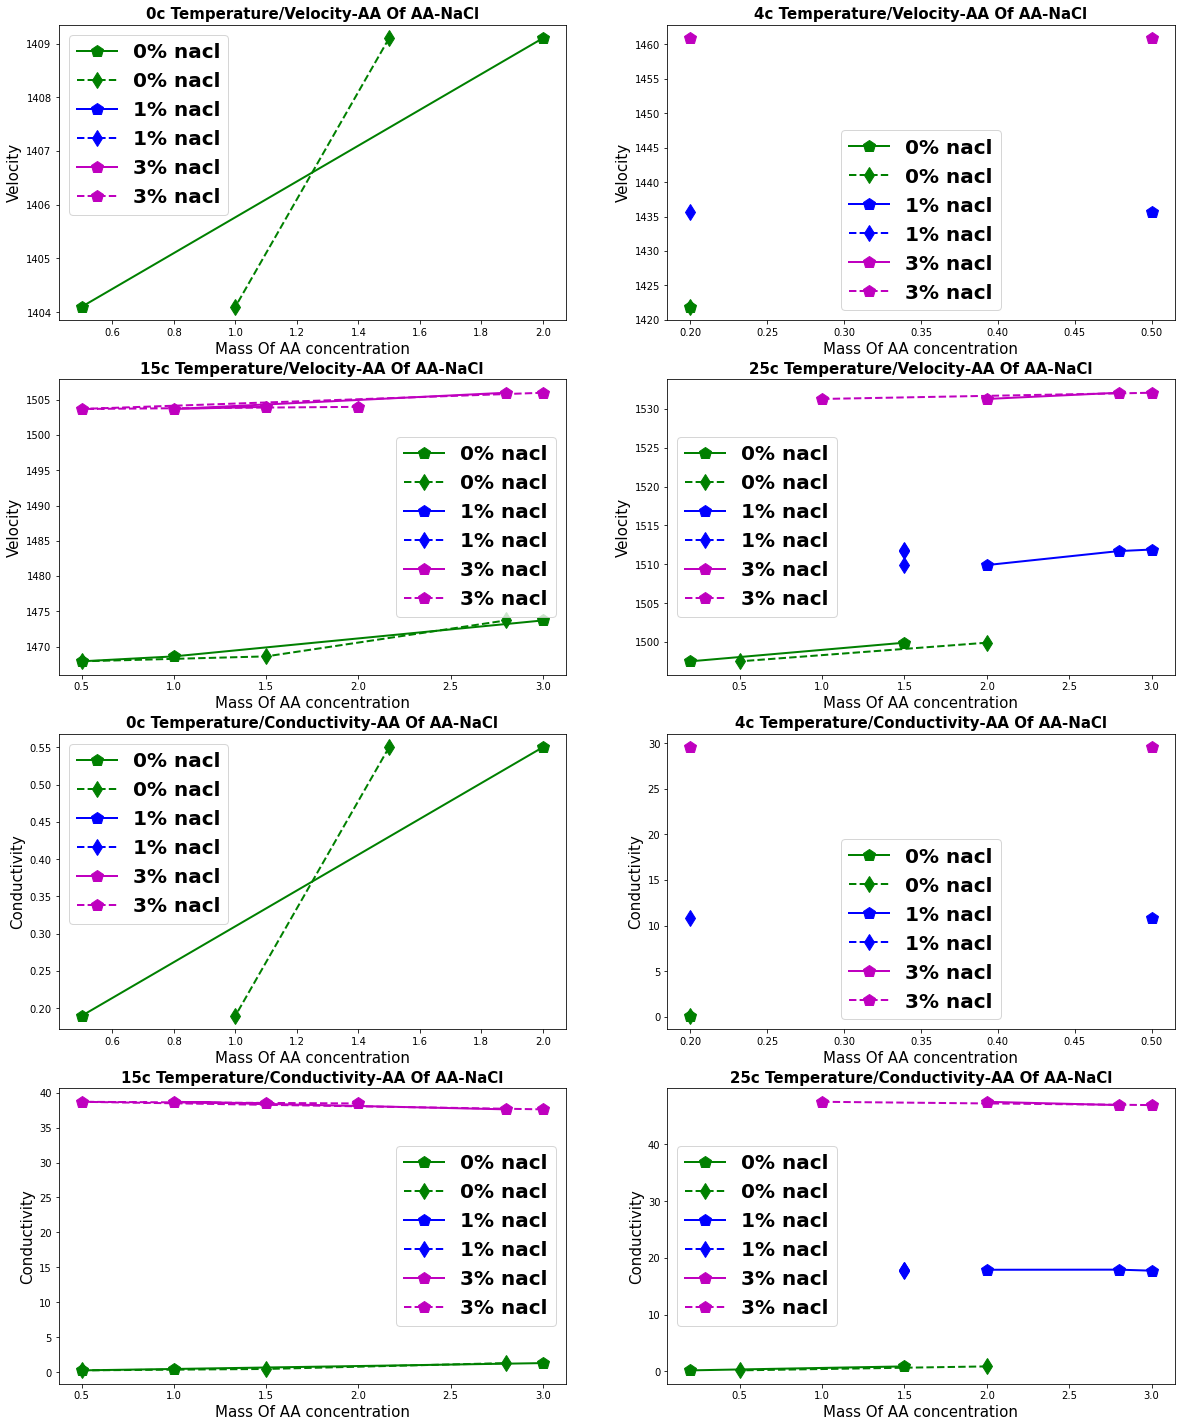

In [238]:
# FOR AA-NACL DATASET
plt.figure(figsize=(20, 25))
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
j = 1
tempt = ['0','4','15','25']
dataset = [aaNoT_0,aaNoT_4,aaNoT_15,aaNoT_25] #aaNoT_0 weka_RT_aa_0
dataset2 = [aa_dt_pred_0,aa_dt_pred_4,aa_dt_pred_15,aa_dt_pred_25] #aa_dt_pred_0
# dataset3 = [weka_RT_aa_0,weka_RT_aa_4,weka_RT_aa_15,weka_RT_aa_25] #aa_dt_pred_0

for i in range(4):
    plt.subplot(4,2,j)
    hydrateNaclCurvePred2(dataset[i],dataset2[i],'aa','velocity','nacl',
                          tempt[i]+'c Temperature/Velocity-AA Of AA-NaCl','Mass Of AA concentration','Velocity',
                          0,1,3)
    j = j + 1

# FOR CONDUCTIVITY
j = 5
for i in range(4):
    plt.subplot(4,2,j)
    hydrateNaclCurvePred2(dataset[i],dataset2[i],'aa','conductivity',
                          'nacl',tempt[i]+'c Temperature/Conductivity-AA Of AA-NaCl','Mass Of AA concentration','Conductivity',
                          0,1,3)
    j = j + 1

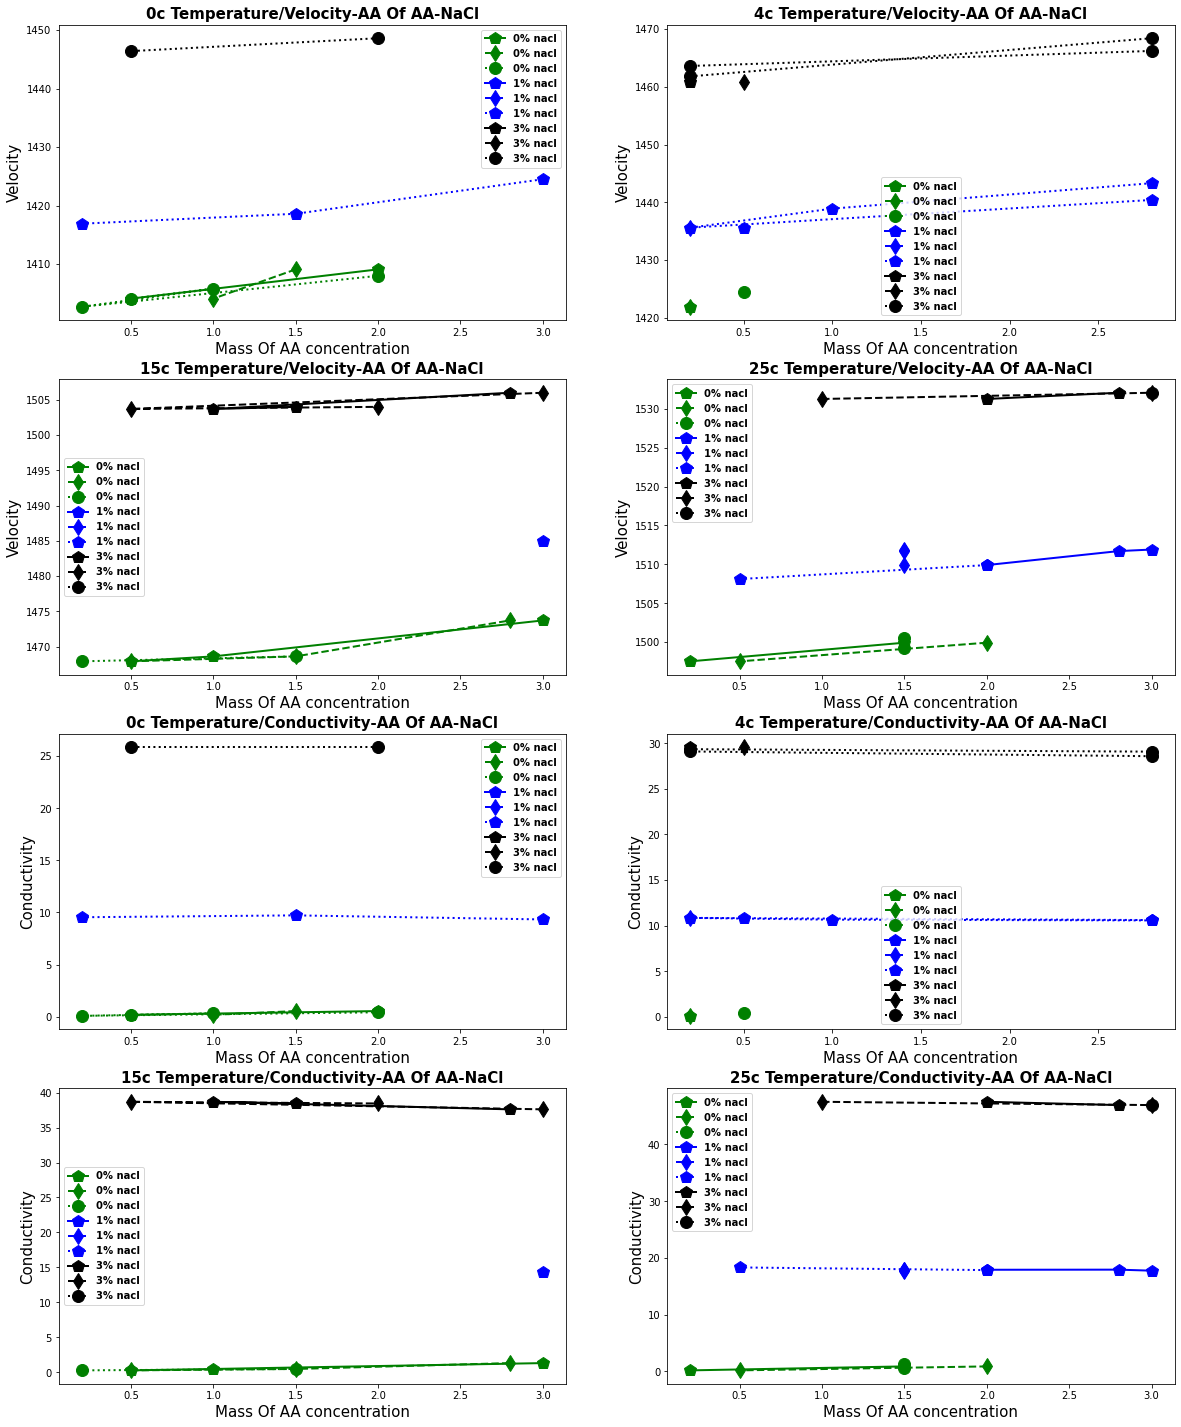

In [255]:
# FOR AA-NACL DATASET
plt.figure(figsize=(20, 25))
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
j = 1
tempt = ['0','4','15','25']
dataset = [aaNoT_0,aaNoT_4,aaNoT_15,aaNoT_25] #aaNoT_0 weka_RT_aa_0
dataset2 = [aa_dt_pred_0,aa_dt_pred_4,aa_dt_pred_15,aa_dt_pred_25] #aa_dt_pred_0
dataset3 = [weka_RT_aa_0,weka_RT_aa_4,weka_RT_aa_15,weka_RT_aa_25] #aa_dt_pred_0

for i in range(4):
    plt.subplot(4,2,j)
    hydrateNaclCurvePred3(dataset[i],dataset2[i],dataset3[i],'aa','velocity','nacl',
                          tempt[i]+'c Temperature/Velocity-AA Of AA-NaCl','Mass Of AA concentration','Velocity',
                          0,1,3)
    j = j + 1

# FOR CONDUCTIVITY
j = 5
for i in range(4):
    plt.subplot(4,2,j)
    hydrateNaclCurvePred3(dataset[i],dataset2[i],dataset3[i],'aa','conductivity',
                          'nacl',tempt[i]+'c Temperature/Conductivity-AA Of AA-NaCl','Mass Of AA concentration','Conductivity',
                          0,1,3)
    j = j + 1

## FEATURETOOLS FEATURE EXTRACTION

In [461]:
es = ft.EntitySet(id = 'hydrate')
es.entity_from_dataframe(entity_id = 'train_df', dataframe = X_train_org, index = 'Id')
# entities = {
#     "cond_df" : (X_train, "id"),
#     "vel_df" : (X_train, "id")}

C:\Program Data\envs\Tensorflow\lib\site-packages\featuretools\entityset\entity.py:463: UserWarning: index Id not found in dataframe, creating new integer column
  "integer column".format(index))


Entityset: hydrate
  Entities:
    train_df [Rows: 84, Columns: 4]
  Relationships:
    No relationships

In [462]:
# relationships = [("cond_df", "id", "cond_df", "conductivity"),
#                  ("vel_df", "id", "vel_df", "velocity")]

In [463]:
es["train_df"].variables

[<Variable: Id (dtype = index)>,
 <Variable: temp (dtype = numeric)>,
 <Variable: conductivity (dtype = numeric)>,
 <Variable: velocity (dtype = numeric)>]

In [464]:
es = es.normalize_entity(base_entity_id='train_df', new_entity_id='conductivity', index='conductivity')
es = es.normalize_entity(base_entity_id='train_df', new_entity_id='velocity', index='velocity')

*  tell DFS to ignore the PassengerId column( we don't want to generate any features for it) using the command ignore_variables={'Passengers':['PassengerId']}),

In [466]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
    target_entity = 'train_df', 
    max_depth = 2, 
    verbose = 3, 
    n_jobs = 1)

Built 21 features
Elapsed: 00:01 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [467]:
Xf_train=feature_matrix.copy() # save the generated features back into our X_Train
feature_matrix.head().T

Id,0,1,2,3,4
temp,4.000000,4.000000,15.000000,4.000000,4.000000
conductivity,29.090000,0.940000,0.680000,0.100000,10.650000
velocity,1468.400024,1431.599976,1470.400024,1421.900024,1438.900024
conductivity.COUNT(train_df),1.000000,1.000000,1.000000,1.000000,1.000000
conductivity.MAX(train_df.temp),4.000000,4.000000,15.000000,4.000000,4.000000
conductivity.MEAN(train_df.temp),4.000000,4.000000,15.000000,4.000000,4.000000
conductivity.MIN(train_df.temp),4.000000,4.000000,15.000000,4.000000,4.000000
conductivity.MODE(train_df.velocity),1468.400024,1431.599976,1470.400024,1421.900024,1438.900024
conductivity.NUM_UNIQUE(train_df.velocity),1.000000,1.000000,1.000000,1.000000,1.000000
conductivity.SKEW(train_df.temp),NaN,NaN,NaN,NaN,NaN


* Repeat the steps for Encoding our training set

In [469]:
feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_names, include_unknown=False)
feature_matrix_enc.head()

,temp,conductivity = 37.599998474121094,conductivity = 26.290000915527344,conductivity = 25.829999923706055,conductivity = 25.360000610351562,conductivity = 25.18000030517578,conductivity = 9.420000076293945,conductivity = 9.359999656677246,conductivity = 9.329999923706055,conductivity = 9.3100004196167,...,velocity.MODE(train_df.conductivity) = 26.290000915527344,velocity.MODE(train_df.conductivity) = 25.829999923706055,velocity.MODE(train_df.conductivity) = 25.360000610351562,velocity.MODE(train_df.conductivity) = 25.18000030517578,velocity.MODE(train_df.conductivity) = 17.940000534057617,velocity.MODE(train_df.conductivity) = 17.850000381469727,velocity.NUM_UNIQUE(train_df.conductivity),velocity.SKEW(train_df.temp),velocity.STD(train_df.temp),velocity.SUM(train_df.temp)
Id,,,,,,,,,,,,,,,,,,,,,
0,4.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,1.0,NaN,NaN,4.0
1,4.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,1.0,NaN,NaN,4.0
2,15.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,1.0,NaN,NaN,15.0
3,4.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2.0,0.585583,5.033223,14.0
4,4.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,1.0,NaN,NaN,4.0


In [470]:
Xf_train = feature_matrix_enc.copy()
Xf_train.head()

,temp,conductivity = 37.599998474121094,conductivity = 26.290000915527344,conductivity = 25.829999923706055,conductivity = 25.360000610351562,conductivity = 25.18000030517578,conductivity = 9.420000076293945,conductivity = 9.359999656677246,conductivity = 9.329999923706055,conductivity = 9.3100004196167,...,velocity.MODE(train_df.conductivity) = 26.290000915527344,velocity.MODE(train_df.conductivity) = 25.829999923706055,velocity.MODE(train_df.conductivity) = 25.360000610351562,velocity.MODE(train_df.conductivity) = 25.18000030517578,velocity.MODE(train_df.conductivity) = 17.940000534057617,velocity.MODE(train_df.conductivity) = 17.850000381469727,velocity.NUM_UNIQUE(train_df.conductivity),velocity.SKEW(train_df.temp),velocity.STD(train_df.temp),velocity.SUM(train_df.temp)
Id,,,,,,,,,,,,,,,,,,,,,
0,4.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,1.0,NaN,NaN,4.0
1,4.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,1.0,NaN,NaN,4.0
2,15.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,1.0,NaN,NaN,15.0
3,4.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2.0,0.585583,5.033223,14.0
4,4.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,1.0,NaN,NaN,4.0


Now create a new entity set for test and repeat the steps for adding the Passengers and PClass entities¶

In [471]:
es_tst = ft.EntitySet(id = 'hydrate')
es_tst.entity_from_dataframe(entity_id = 'train_df', dataframe = X_test_org, index = 'Id')
es_tst = es_tst.normalize_entity(base_entity_id='train_df', new_entity_id='conductivity', index='conductivity')
es_tst = es_tst.normalize_entity(base_entity_id='train_df', new_entity_id='velocity', index='velocity')

C:\Program Data\envs\Tensorflow\lib\site-packages\featuretools\entityset\entity.py:463: UserWarning: index Id not found in dataframe, creating new integer column
  "integer column".format(index))


### Now call calculate_feature_matrix on our test entity set and pass in the list of saved features from training¶

In [473]:
feature_matrix_tst = ft.calculate_feature_matrix(features=features_enc, entityset=es_tst)

In [474]:
Xf_test = feature_matrix_tst.copy()
Xf_test.head(2)

,temp,conductivity = 37.599998474121094,conductivity = 26.290000915527344,conductivity = 25.829999923706055,conductivity = 25.360000610351562,conductivity = 25.18000030517578,conductivity = 9.420000076293945,conductivity = 9.359999656677246,conductivity = 9.329999923706055,conductivity = 9.3100004196167,...,velocity.MODE(train_df.conductivity) = 26.290000915527344,velocity.MODE(train_df.conductivity) = 25.829999923706055,velocity.MODE(train_df.conductivity) = 25.360000610351562,velocity.MODE(train_df.conductivity) = 25.18000030517578,velocity.MODE(train_df.conductivity) = 17.940000534057617,velocity.MODE(train_df.conductivity) = 17.850000381469727,velocity.NUM_UNIQUE(train_df.conductivity),velocity.SKEW(train_df.temp),velocity.STD(train_df.temp),velocity.SUM(train_df.temp)
Id,,,,,,,,,,,,,,,,,,,,,
0,0.0,False,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,1.0,NaN,NaN,0.0
1,15.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,1.0,NaN,NaN,15.0


In [563]:
# double check for nulls
for index,col in enumerate(drop_col):
#     print(col)
    if drop_col[index] in Xf_trainAdd:
        print(col)
        Xf_trainAdd.drop(col, axis=1, inplace=True)

In [399]:
model = Sequential()
model.add(Dense(4, input_dim=in_dim, activation="relu"))
model.add(Dense(3, activation="relu"))
model.add(Dense(out_dim))
model.compile(loss="mse", optimizer="adam")
# model.compile(loss='mae', optimizer='adam')
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 15        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 8         
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________


In [401]:
from tensorflow import keras
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [402]:
model.fit(xtrain, ytrain, epochs=100, batch_size=12, verbose=0)

In [403]:
ypred = model.predict(xtest)
print("y1 MSE:%.4f" % mean_squared_error(ytest[:,0], ypred[:,0])) 
print("y2 MSE:%.4f" % mean_squared_error(ytest[:,1], ypred[:,1]))

y1 MSE:22771.3418
y2 MSE:0.9704


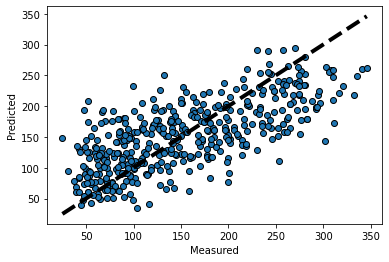

In [126]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

lr = linear_model.LinearRegression()
X, y = datasets.load_diabetes(return_X_y=True)

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [1]:
import jupyterthemes as jt
# !jt -t oceans16
!jt -r
# Available themes:
# onedork grade3 oceans16 chesterish monokai solarizedl solarizedd

Reset css and font defaults in:
C:\Users\FOS\.jupyter\custom &
C:\Users\FOS\AppData\Roaming\jupyter\nbextensions
